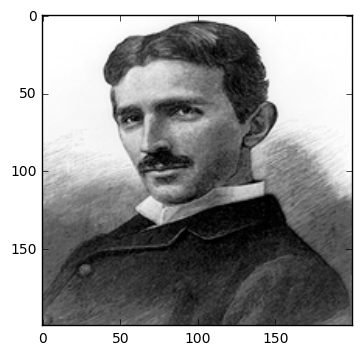

[[ 26.25423622  24.08924103  25.07882118 ...,  21.87107468  25.27858734
   29.50329208]]


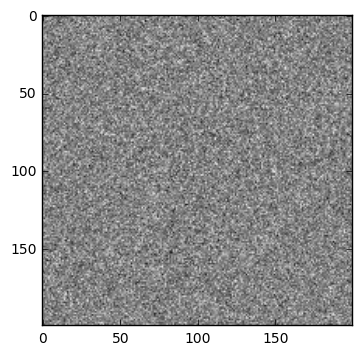

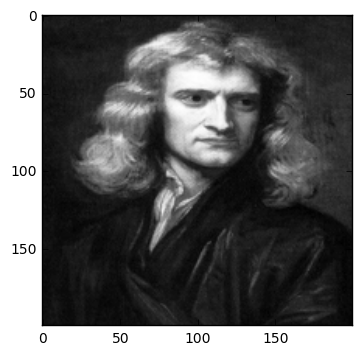

[[ 25.  25.  25. ...,  25.  25.  25.]]


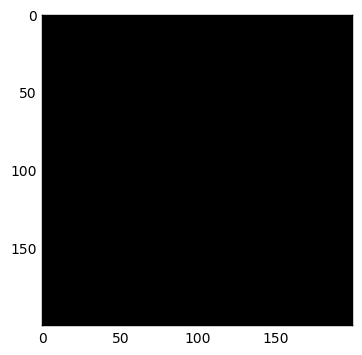

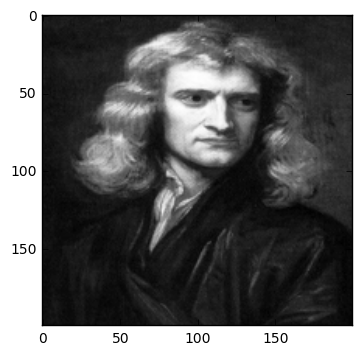

[[ 25.  25.  25. ...,  25.  25.  25.]]


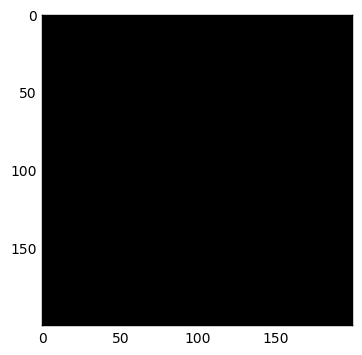

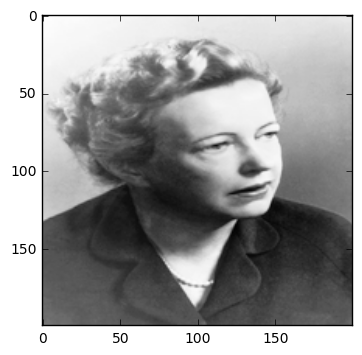

[[ 25.15740585  24.54918289  24.65764236 ...,  23.88895988  25.26607132
   24.7331028 ]]


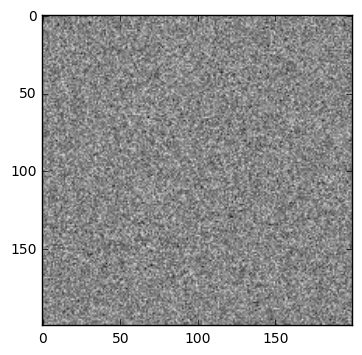

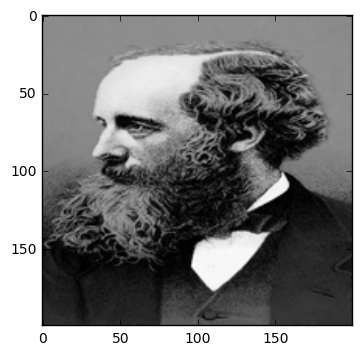

[[ 24.71139336  24.91761208  23.66994476 ...,  24.00543404  26.13763809
   25.51323891]]


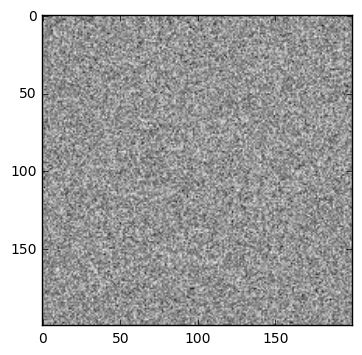

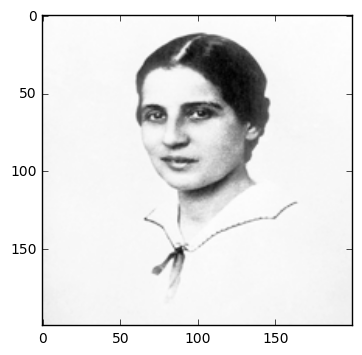

[[ 25.  25.  25. ...,  25.  25.  25.]]


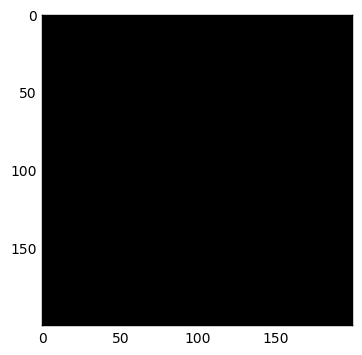

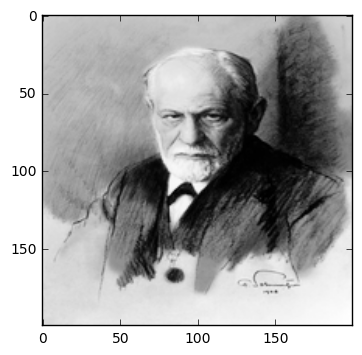

[[ 25.  25.  25. ...,  25.  25.  25.]]


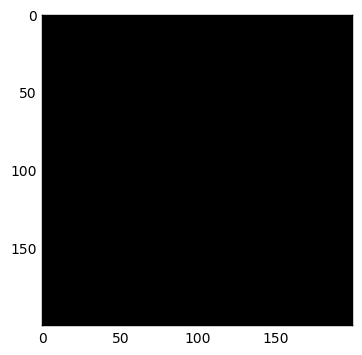

In [5]:
import theano 
from theano import tensor as T 
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 

srng = RandomStreams()

def dropout(X, p=0.): 
    if p > 0: 
        retain_prob = 1 - p 
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX) 
        X /= retain_prob 
    return X 

def rectify(X): 
    return T.maximum(X, 0.) 

def softmax(X): 
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x')) 
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x') 

def floatX(X): 
    return np.asarray(X, dtype=theano.config.floatX) 

def init_weights(shape): 
    return theano.shared(floatX(np.random.randn(*shape) * 0.01)) 

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6): 
    grads = T.grad(cost=cost, wrt=params) 
    updates = [] 
    for p, g in zip(params, grads): 
        acc = theano.shared(p.get_value() * 0.) 
        acc_new = rho * acc + (1 - rho) * g ** 2 
        gradient_scaling = T.sqrt(acc_new + epsilon) 
        g = g / gradient_scaling 
        updates.append((acc, acc_new)) 
        updates.append((p, p - lr * g)) 
    return updates 

w_h1 = init_weights((40000, 400)) 
w_h2 = init_weights((400, 200)) 
w_h3 = init_weights((200, 40000)) 

def model(X,w_h1,w_h2,w_h3,p_drop_input=0.0, p_drop_hidden=0.0):
    X = dropout(X, p_drop_input) 
    w_o_h1=rectify(T.dot(X, w_h1)) 
    w_o_h1= dropout(w_o_h1, p_drop_input) 
    w_o_h2=rectify(T.dot(w_o_h1, w_h2)) 
    w_o_h2= dropout(w_o_h2, p_drop_input) 
    y_x = softmax(T.dot(w_o_h2, w_h3)) 
    return y_x 


X = T.fmatrix() 
Y = T.fmatrix() 

y_x = model(X,w_h1,w_h2,w_h3)
cost = T.mean(T.nnet.categorical_crossentropy(y_x, Y))
params = [w_h1,w_h2,w_h3]
updates = RMSprop(cost, params, lr=0.001) 
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True) 
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True) 

import PIL
from PIL import Image
import requests
from io import BytesIO

for i in range(100):
    with open("../Environment/Informations/Content/Portraits/trainImages/images.txt") as f:
        infoFileContents = f.readlines()
        for l in range(len(infoFileContents)):
            infoLine = infoFileContents[l].lstrip().rstrip()
            response = requests.get(infoLine)

            trainInpImg = Image.open(BytesIO(response.content))
            trainInpGrayImg = trainInpImg.convert("L")
            trainInpGrayImg = trainInpGrayImg.resize((200,200), PIL.Image.ANTIALIAS)
            trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.uint8).ravel()

            trainOutImg = Image.open(BytesIO(response.content))
            trainOutGrayImg = trainOutImg.convert("L")
            trainOutGrayImg = trainOutGrayImg.resize((200,200), PIL.Image.ANTIALIAS)
            trainOutGreyImgArray = np.asarray(trainOutGrayImg, dtype=np.uint8).ravel()

            cost = train([trainInpGreyImgArray], [trainOutGreyImgArray])

with open("../Environment/Informations/Content/Portraits//testImages/images.txt") as f:
    infoFileContents = f.readlines()
    for l in range(len(infoFileContents)):
        infoLine = infoFileContents[l].lstrip().rstrip()
        response = requests.get(infoLine)
        
        trainInpImg = Image.open(BytesIO(response.content))
        trainInpGrayImg = trainInpImg.convert("L")
        trainInpGrayImg = trainInpGrayImg.resize((200,200), PIL.Image.ANTIALIAS)
        trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.uint8).ravel()
        
        plt.imshow(trainInpGrayImg, cmap = cm.Greys_r)
        plt.show()
        
        predImgArray = predict([trainInpGreyImgArray])
        predImgArray *= 100000
        print (predImgArray)
        plt.imshow(predImgArray.reshape(200,200), cmap = cm.Greys_r)
        plt.show()
